In [48]:
import tensorflow as tf

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

In [49]:
csv_path = "Measurement_summary.csv"

In [50]:
df = pd.read_csv(csv_path)

In [51]:
df.head()

,Measurement date,Station code,Address,Latitude,Longitude,SO2,NO2,O3,CO,PM10,PM2.5
0,2017-01-01 00:00,101,"19, Jong-ro 35ga-gil, Jongno-gu, Seoul, Republ...",37.572016,127.005007,0.004,0.059,0.002,1.2,73.0,57.0
1,2017-01-01 01:00,101,"19, Jong-ro 35ga-gil, Jongno-gu, Seoul, Republ...",37.572016,127.005007,0.004,0.058,0.002,1.2,71.0,59.0
2,2017-01-01 02:00,101,"19, Jong-ro 35ga-gil, Jongno-gu, Seoul, Republ...",37.572016,127.005007,0.004,0.056,0.002,1.2,70.0,59.0
3,2017-01-01 03:00,101,"19, Jong-ro 35ga-gil, Jongno-gu, Seoul, Republ...",37.572016,127.005007,0.004,0.056,0.002,1.2,70.0,58.0
4,2017-01-01 04:00,101,"19, Jong-ro 35ga-gil, Jongno-gu, Seoul, Republ...",37.572016,127.005007,0.003,0.051,0.002,1.2,69.0,61.0


The function below returns the above described windows of time for the model to train on. The parameter history_size is the size of the past window of information. The target_size is how far in the future does the model need to learn to predict. The target_size is the label that needs to be predicted.

In [52]:
def univariate_data(dataset, start_index, end_index, history_size, target_size):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i)
    # Reshape data from (history_size,) to (history_size, 1)
    data.append(np.reshape(dataset[indices], (history_size, 1)))
    labels.append(dataset[i+target_size])
  return np.array(data), np.array(labels)


In [53]:
TRAIN_SPLIT = 300000

In [54]:
tf.random.set_seed(13)

Part 1: Forecast a univariate time series

First, you will train a model using only a single feature (PM10), and use it to make predictions for that value in the future.

Let's first extract only the PM10 from the dataset.

In [55]:
uni_data = df['PM10']
uni_data.index = df['Measurement date']
uni_data.head()

Measurement date
2017-01-01 00:00    73.0
2017-01-01 01:00    71.0
2017-01-01 02:00    70.0
2017-01-01 03:00    70.0
2017-01-01 04:00    69.0
Name: PM10, dtype: float64

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000002949174AA08>],
      dtype=object)

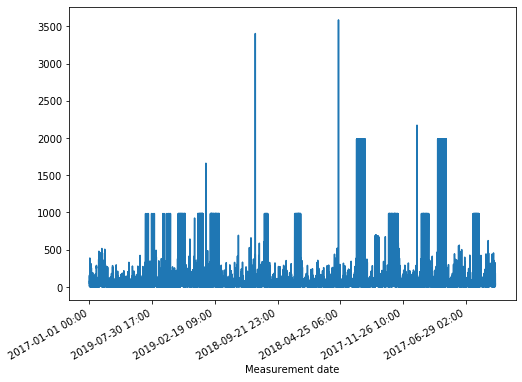

In [56]:
uni_data.plot(subplots=True)

In [57]:
uni_data = uni_data.values

It is important to scale features before training a neural network. Standardization is a common way of doing this scaling by subtracting the mean and dividing by the standard deviation of each feature.You could also use a tf.keras.utils.normalize method that rescales the values into a range of [0,1].

In [58]:
uni_train_mean = uni_data[:TRAIN_SPLIT].mean()
uni_train_std = uni_data[:TRAIN_SPLIT].std()


Let's standardize the data.

In [59]:
uni_data = (uni_data-uni_train_mean)/uni_train_std

Let's now create the data for the univariate model. For part 1, the model will be given the last 20 recorded PM10 observations , and needs to learn to predict the PM10 value at the next time step.
Note: i tried 20 first and the results are worse so lets run with 100 recorded observations

In [60]:
univariate_past_history = 100
univariate_future_target = 0

x_train_uni, y_train_uni = univariate_data(uni_data, 0, TRAIN_SPLIT,
                                           univariate_past_history,
                                           univariate_future_target)
x_val_uni, y_val_uni = univariate_data(uni_data, TRAIN_SPLIT, None,
                                       univariate_past_history,
                                       univariate_future_target)


In [61]:
print ('Single window of past history')
print (x_train_uni[0])
print ('\n Target PM10 observation to predict')
print (y_train_uni[0])


Single window of past history
[[ 0.63835065]
 [ 0.59778684]
 [ 0.57750493]
 [ 0.57750493]
 [ 0.55722303]
 [ 0.57750493]
 [ 0.49637731]
 [ 0.59778684]
 [ 0.61806874]
 [ 0.65863255]
 [ 0.69919636]
 [ 0.84116969]
 [ 1.04398874]
 [ 1.06427065]
 [ 1.04398874]
 [ 0.92229731]
 [ 0.92229731]
 [ 1.00342493]
 [ 1.00342493]
 [ 1.02370684]
 [ 1.06427065]
 [ 1.04398874]
 [ 0.96286112]
 [ 1.00342493]
 [ 1.04398874]
 [ 1.02370684]
 [ 0.98314303]
 [ 1.02370684]
 [ 1.02370684]
 [ 1.02370684]
 [ 1.02370684]
 [ 0.94257922]
 [ 0.94257922]
 [ 0.94257922]
 [ 0.8817335 ]
 [ 0.63835065]
 [ 0.78032398]
 [ 1.2670897 ]
 [ 1.53075446]
 [ 1.79441922]
 [ 1.99723827]
 [ 2.15949351]
 [ 2.20005732]
 [ 2.40287637]
 [ 2.28118494]
 [ 2.26090304]
 [ 2.1189297 ]
 [ 2.0986478 ]
 [ 2.15949351]
 [ 2.03780208]
 [ 1.63216398]
 [ 1.18596208]
 [ 1.08455255]
 [ 1.06427065]
 [ 0.84116969]
 [ 0.61806874]
 [ 0.69919636]
 [ 0.82088779]
 [ 0.69919636]
 [ 0.67891446]
 [ 0.67891446]
 [ 0.59778684]
 [ 0.69919636]
 [ 0.35440398]
 [ 0.21243

Now that the data has been created, let's take a look at a single example. The information given to the network is given in blue, and it must predict the value at the red cross.

In [62]:
def create_time_steps(length):
  return list(range(-length, 0))


In [63]:
def show_plot(plot_data, delta, title):
  labels = ['History', 'True Future', 'Model Prediction']
  marker = ['.-', 'rx', 'go']
  time_steps = create_time_steps(plot_data[0].shape[0])
  if delta:
    future = delta
  else:
    future = 0

  plt.title(title)
  for i, x in enumerate(plot_data):
    if i:
      plt.plot(future, plot_data[i], marker[i], markersize=10,
               label=labels[i])
    else:
      plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
  plt.legend()
  plt.xlim([time_steps[0], (future+5)*2])
  plt.xlabel('Time-Step')
  return plt

<module 'matplotlib.pyplot' from 'C:\\Users\\richa\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

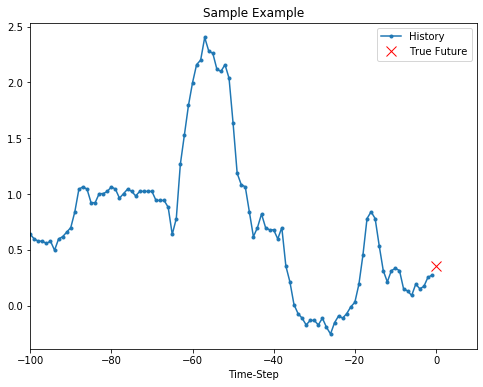

In [64]:
show_plot([x_train_uni[0], y_train_uni[0]], 0, 'Sample Example')


Baseline
Before proceeding to train a model, let's first set a simple baseline. Given an input point, the baseline method looks at all the history and predicts the next point to be the average of the last 100 observations.

In [65]:
def baseline(history):
  return np.mean(history)


<module 'matplotlib.pyplot' from 'C:\\Users\\richa\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

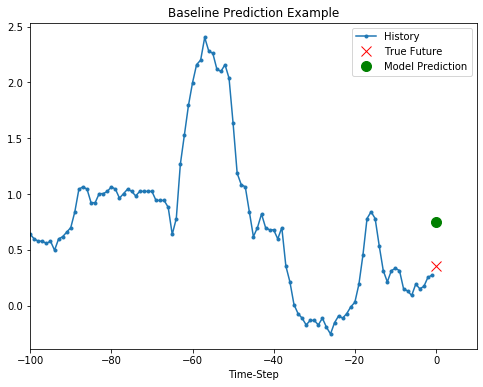

In [66]:
show_plot([x_train_uni[0], y_train_uni[0], baseline(x_train_uni[0])], 0,
           'Baseline Prediction Example')


Let's see if you can beat this baseline using a recurrent neural network.
Recurrent neural network

A Recurrent Neural Network (RNN) is a type of neural network well-suited to time series data. RNNs process a time series step-by-step, maintaining an internal state summarizing the information they've seen so far.Lets use a specialized RNN layer called Long Short Term Memory (LSTM)

Let's now use tf.data to shuffle, batch, and cache the dataset.

In [67]:
BATCH_SIZE = 256
BUFFER_SIZE = 10000

train_univariate = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_univariate = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()


You will see the LSTM requires the input shape of the data it is being given.

In [68]:
simple_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(8, input_shape=x_train_uni.shape[-2:]),
    tf.keras.layers.Dense(1)
])

simple_lstm_model.compile(optimizer='adam', loss='mae')


Let's make a sample prediction, to check the output of the model. 

In [69]:
for x, y in val_univariate.take(1):
    print(simple_lstm_model.predict(x).shape)


(256, 1)


Let's train the model now. Due to the large size of the dataset, in the interest of saving time, each epoch will only run for 200 steps, instead of the complete training data as normally done.

In [70]:
EVALUATION_INTERVAL = 200
EPOCHS = 10

simple_lstm_model.fit(train_univariate, epochs=EPOCHS,
                      steps_per_epoch=EVALUATION_INTERVAL,
                      validation_data=val_univariate, validation_steps=50)


Train for 200 steps, validate for 50 steps
Epoch 1/10
200/200 [==============================] - 11s 55ms/step - loss: 0.2135 - val_loss: 0.2115
Epoch 2/10
200/200 [==============================] - 8s 42ms/step - loss: 0.1681 - val_loss: 0.1480
Epoch 3/10
200/200 [==============================] - 8s 41ms/step - loss: 0.1766 - val_loss: 0.1260
Epoch 4/10
200/200 [==============================] - 8s 42ms/step - loss: 0.2205 - val_loss: 0.1191
Epoch 5/10
200/200 [==============================] - 9s 43ms/step - loss: 0.1208 - val_loss: 0.1160
Epoch 6/10
200/200 [==============================] - 9s 43ms/step - loss: 0.1276 - val_loss: 0.1150
Epoch 7/10
200/200 [==============================] - 9s 44ms/step - loss: 0.0924 - val_loss: 0.1142
Epoch 8/10
200/200 [==============================] - 9s 44ms/step - loss: 0.1232 - val_loss: 0.1141
Epoch 9/10
200/200 [==============================] - 9s 44ms/step - loss: 0.1680 - val_loss: 0.1137
Epoch 10/10
200/200 [==========================

Predict using the simple LSTM model

Now that you have trained your simple LSTM, let's try and make a few predictions.

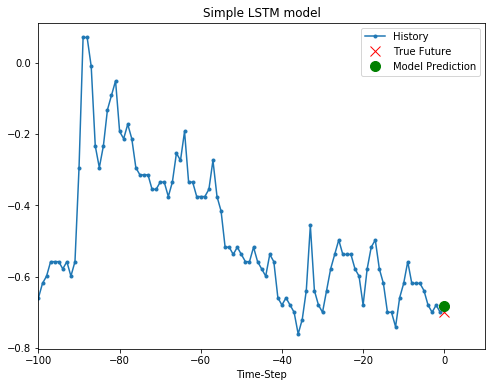

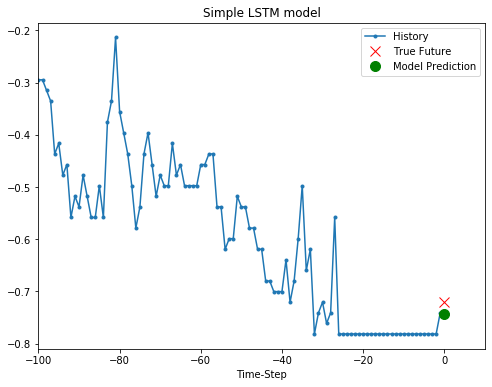

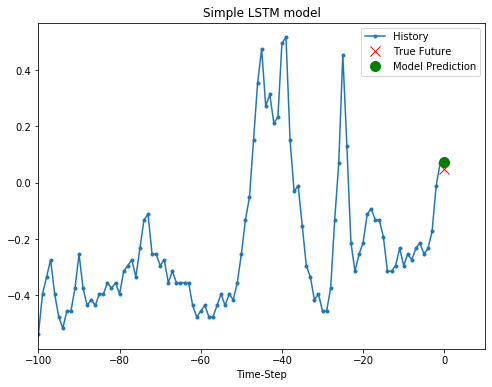

[0.07494852]
0.05017540446704798


In [71]:
for x, y in val_univariate.take(3):
  plot = show_plot([x[0].numpy(), y[0].numpy(),
                    simple_lstm_model.predict(x)[0]], 0, 'Simple LSTM model')
  plot.show()


In [72]:
from sklearn.metrics import mean_squared_error
#expected = y_train_uni#[0]
#expected = y[0].numpy()
#predictions = simple_lstm_model.predict(x)[0]
#predictions.tolist()
#mse = mean_squared_error(expected, predictions)
#print(mse)
#print(mean_squared_error(y_train_uni,simple_lstm_model.predict))

In [93]:
y_pred = simple_lstm_model.predict(x)[0]
y_true = np.array(y_train_uni)[0]
print(np.power(y_true - y_pred, 2))

[0.07809535]


In [94]:
print(simple_lstm_model.predict(x)[:])


[[ 0.07494852]
 [ 0.05350936]
 [-0.27738604]
 [-0.37355512]
 [-0.23201138]
 [-0.4591364 ]
 [-0.50451666]
 [-0.49465713]
 [-0.51274085]
 [-0.5656128 ]
 [-0.58868504]
 [-0.6268846 ]
 [-0.6004721 ]
 [-0.6328098 ]
 [-0.6203574 ]
 [-0.6045117 ]
 [-0.5865137 ]
 [-0.6177429 ]
 [-0.62125796]
 [-0.6559887 ]
 [-0.64493376]
 [-0.661697  ]
 [-0.6956648 ]
 [-0.716779  ]
 [-0.7065024 ]
 [-0.7069302 ]
 [-0.7070338 ]
 [-0.7534584 ]
 [-0.76043993]
 [-0.76476735]
 [-0.7518038 ]
 [-0.70476097]
 [-0.71274096]
 [-0.71132326]
 [-0.68018204]
 [-0.6916569 ]
 [-0.6915446 ]
 [-0.69184065]
 [-0.6918516 ]
 [-0.67598283]
 [-0.7051186 ]
 [-0.7080377 ]
 [-0.70980215]
 [-0.6948131 ]
 [-0.661149  ]
 [-0.71870565]
 [-0.7243496 ]
 [-0.6657141 ]
 [-0.6897459 ]
 [-0.7054207 ]
 [-0.6451947 ]
 [-0.66991603]
 [-0.60540587]
 [-0.59759027]
 [-0.6430408 ]
 [-0.54831326]
 [-0.5552583 ]
 [-0.48349229]
 [-0.4401026 ]
 [-0.45168757]
 [-0.46847087]
 [-0.46916553]
 [-0.4156784 ]
 [-0.39238468]
 [-0.33435795]
 [-0.3292532 ]
 [-0.36432